## 1D example
This notebook shows how to run and analyse a 1D plane-wave collapse simulation with DISCO-DJ.
Also, it motivates the use of Zel'dovich-consistent integrators such as BullFrog (the default in DiscoDJ) for cosmological simulations.

### Imports

In [3]:
# Import modules
from matplotlib import pyplot as plt
# %matplotlib notebook
%matplotlib inline
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
sns.set_style("ticks")
from jax import config
import numpy as np
from discodj import DiscoDJ
plt.rcParams['image.cmap'] = "rocket"

In [4]:
# Set the parameters
name = "1D_analysis"
dim = 1
device = "gpu"

precision = "single"
if precision == "double":
    config.update("jax_enable_x64", True)

# Define the cosmology (n_s and sigma8 are meaningless, as we consider a single plane wave)
cosmo = dict(Omega_c=0.25,
             Omega_b=0.05,
             Omega_k=0.0,
             h=0.6774,
             n_s=0.0,
             sigma8=0.0,
             w0=-1.0,
             wa=0.0)

# Define the boxsize and resolution
boxsize = 1.0
res = 1000

# Define DISCO-DJ object
dj = DiscoDJ(dim=dim, res=res, name=name, device=device, precision=precision, boxsize=boxsize, cosmo=cosmo)
print(dj)

DiscoDJ
——————————
Name: 1D_analysis
Dimensions: 1D
Resolution: 1000 particles
Boxsize: 1.0 Mpc/h
Precision: single
Device: gpu
Cosmology:
  Omega_c: 0.2500 
  Omega_b: 0.0500 
  Omega_de: 0.7000 
  h: 0.6774 
  n_s: 0.0000 
  sigma8: 0.0000 
  Omega_k: 0.0000 
  w0: -1.0000 
  wa: 0.0000


In [5]:
# Compute the timetables for the growth and the linear power spectrum (in 1D, we do not use any transfer function)
dj = dj.with_timetables()
dj = dj.with_linear_ps(transfer_function="none")

### Initial conditions
Let's consider the collapse of a single plane wave that shell-crosses at a_cross = 0.2 (i.e., at that time particle trajectories cross for the first time in the middle of the box).

In [6]:
a_cross = 0.2
dj = dj.with_ics_plane_wave(a_cross=a_cross, A_dec=0.0, from_potential=True)  # we don't use a decaying mode here

In 1D, the Zel'dovich "approximation" is the exact solution before shell-crossing. Let's compute the Zel'dovich solution (1LPT), which we can then evaluate at arbitrary times.

In [7]:
n_order = 1
dj = dj.with_lpt(n_order=n_order, grad_kernel_order=0, convert_to_numpy=True)

Now, let's do a single step of an N-body simulation starting from a = a_ini and compare the result with the Zel'dovich solution before shell-crossing.

In [8]:
a_ini = 0.05
a_end = 0.15

In 1D, we can compute the acceleration exactly by counting particles left and right of each mass shell (`method="exact"`).

### Simulation

In [9]:
stepper = "symplectic"  # Standard symplectic leapfrog integrator
time_var = "a"  # Uniform steps in a
n_steps = 1  # Just one step
method = "exact"  # "exact" force computation in 1D via particle counting
psi_1step, P_1step, a_1step = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=n_steps, time_var=time_var, stepper=stepper, method=method, return_displacement=True)

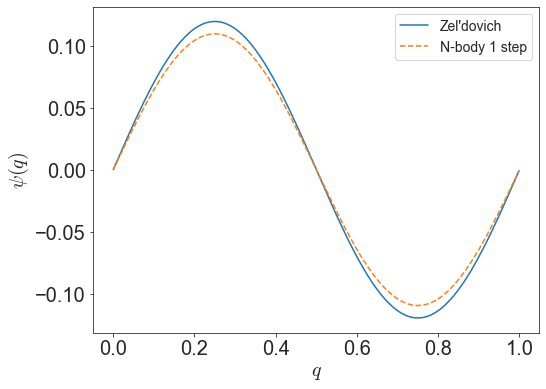

In [10]:
# Plot the resulting particle displacements
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(dj.q, dj.evaluate_lpt_psi_at_a(a_end), label="Zel'dovich")
ax.plot(dj.q, psi_1step, ls="--", label="N-body 1 step")
ax.legend(fontsize=14)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\psi(q)$")
plt.show()

The numerical solution with 1 time step is not quite accurate. This is not a bug in the code, but simply because the symplectic integrator knows nothing about the Zel'dovich solution, and only converges to the correct solution in the limit of many small steps.
Let's do the same again, but perform 1000 steps instead of just one.

In [11]:
psi_1000steps, P_1000steps, a_1000steps = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=1000, time_var="a", stepper=stepper, method="exact", return_displacement=True)

Text(0, 0.5, '$\\psi(q)$')

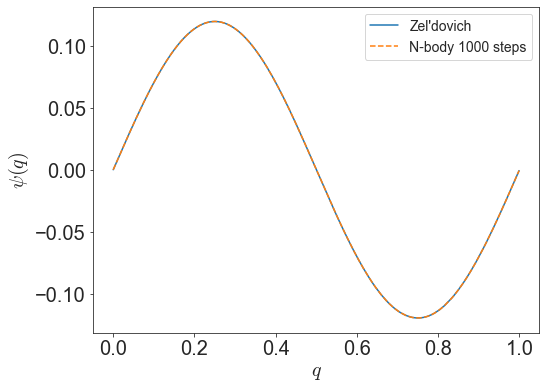

In [12]:
# Plot the resulting particle displacements
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(dj.q, dj.evaluate_lpt_psi_at_a(a_end), label="Zel'dovich")
ax.plot(dj.q, psi_1000steps, ls="--", label="N-body 1000 steps")
ax.legend(fontsize=14)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\psi(q)$")

Now, we see that the numerical solution agrees with the analytical Zel'dovich solution. With a standard symplectic integrator, many timesteps are needed to get close to the solution - although the analytical solution is known in this case! Let us use a "smarter" integrator instead that has Zel'dovich built in (see [here](https://arxiv.org/abs/2301.09655) and [here](https://arxiv.org/abs/2409.19049) for details), and again do just a single step.


In [14]:
stepper = "bullfrog"
psi_bf_1step, P_bf_1step, a_bf_1step = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=1, time_var="a", stepper=stepper, method="exact", return_displacement=True)

Text(0, 0.5, '$\\psi(q)$')

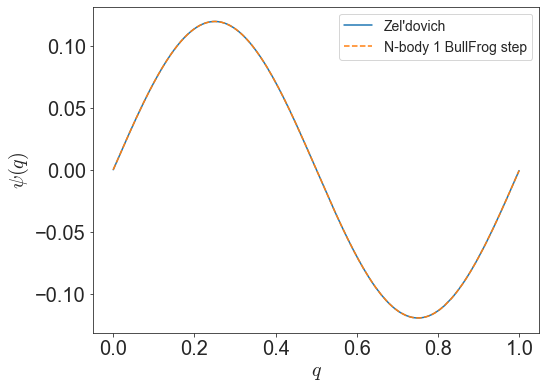

In [15]:
# Plot the resulting particle displacements
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(dj.q, dj.evaluate_lpt_psi_at_a(a_end), label="Zel'dovich")
ax.plot(dj.q, psi_bf_1step, ls="--", label="N-body 1 BullFrog step")
ax.legend(fontsize=14)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\psi(q)$")

A single step (or any other number of steps) with a Zel'dovich-consistent integrator correctly reproduces the Zel'dovich solution before shell-crossing. BullFrog (the default in DiscoDJ) is the unique DKD leapfrog integrator that captures the 1LPT (Zel'dovich) and 2LPT terms exactly, even with a single step. Note that since the 2LPT term vanishes in 1D, the advantage of BullFrog over other Zel'dovich-consistent integrators (e.g. [FastPM](https://arxiv.org/abs/1603.00476)) only becomes apparent in >1D simulations.

### Post shell-crossing
Let us now compare the Zel'dovich solution with the N-body solution after shell-crossing. After shell-crossing, the Zel'dovich solution is no longer valid, and using a Zel'dovich-consistent integrator can no longer be expected to improve the results. Still, as any other second-order integrator, BullFrog converges to the correct solution in the limit of many small steps.

In [16]:
n_steps = 1000
a_end = 0.9

X_sim, P_sim, a_sim = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=n_steps, time_var="a", stepper="bullfrog", method="exact", return_displacement=False, collect_all=True)

Let's make an animation of the Eulerian positions $x(q)$, phase space ($x$ vs $P$), and a scatter plot of some particles.

In [17]:
# Cut off the first and last points because they might wrap to other side of the box due to numerics
X_sim = X_sim[:, 1:-1]
P_sim = P_sim[:, 1:-1]
X_lpt = dj.evaluate_lpt_pos_at_a(a_sim, n_order=1)[:, 1:-1]
P_lpt = dj.evaluate_lpt_psi_dot_at_a(a_sim, n_order=1)[:, 1:-1]

In [ ]:
fig, axs = plt.subplot_mosaic([[0, 1, 2],
                               [0, 1, 3]],
                              figsize=(20.5, 6.5), layout="constrained")
frame = 40
sub_time = 10
sub_space = 100
n_points = len(range(dj.res)[::sub_space])
colors = mpl.cm.Spectral(np.arange(n_points) / n_points)

q = dj.q[1:-1, 0]

def update(frame):
    for i in range(4):
        axs[i].clear()

    # q vs x
    axs[0].plot(q, X_sim[sub_time * frame, :, 0], "k-", label="True (N-body)")
    axs[0].plot(q, X_lpt[sub_time * frame, :, 0], "r--", label="Zel'dovich")
    axs[0].set_title("1D collapse")
    axs[0].legend(loc=2)
    axs[0].set_xlabel(r"Lagrangian position $q$")
    axs[0].set_ylabel(r"Current position $x$")
    axs[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    axs[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))

    # true x vs. v
    axs[1].plot(X_sim[sub_time * frame, :, 0], P_sim[sub_time * frame, :, 0], "k-", label="True (N-body)")
    axs[1].plot(X_lpt[sub_time * frame, :, 0], P_lpt[sub_time * frame, :, 0], "r--", label="Zel'dovich")
    axs[1].set_title("Phase space")
    axs[1].legend(loc=2)
    axs[1].set_xlabel(r"Current position $x$")
    axs[1].set_ylabel(r"Current velocity $v$")
    axs[1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    axs[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    axs[1].set_ylim([-1.2, 1.2])

    # true particle positions
    axs[2].scatter(X_sim[sub_time * frame, sub_space//2::sub_space], np.zeros_like(X_sim[sub_time * frame, sub_space//2::sub_space]), marker="o", c=colors, s=40)
    axs[2].set_yticks([])
    axs[2].set_xlim([0, 1])
    axs[2].set_xticks([])
    axs[2].set_title("True")
    axs[2].set_ylim([-0.5, 0.5])

    # Zel'dovich particle positions
    axs[3].scatter(X_lpt[sub_time * frame, sub_space//2::sub_space], np.zeros_like(X_lpt[sub_time * frame, sub_space//2::sub_space]), marker="o", c=colors, s=40)
    axs[3].set_yticks([])
    axs[3].set_xlabel("Current position $x$")
    axs[3].set_xlim([0, 1])
    axs[3].set_title("Zel'dovich")
    axs[3].set_ylim([-0.5, 0.5])
    axs[3].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))

frames = (n_steps + 1) // sub_time
for i in range(frames):
    update(i)

ani = FuncAnimation(fig, update, frames=(n_steps + 1) // sub_time, interval=50)

# Save as mp4
# ani.save("1d_collapse.mp4")

In [27]:
HTML(ani.to_jshtml())